## Simulating the spin model:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
from ipywidgets import interact, IntSlider
import scipy.linalg as la

In [2]:
from ising_utils import *

Logic for code below:
- the matrix _path_ is the adjacency matrix of a path graph
- the kronecker sum of offdi with itself is the grid graph (see https://en.wikipedia.org/wiki/Kronecker_product#Abstract_properties)
- code partly from https://stackoverflow.com/questions/16329403/how-can-you-make-an-adjacency-matrix-which-would-emulate-a-2d-grid
- other resource on creating lattice graphs: https://mathworld.wolfram.com/GraphCartesianProduct.html

In [3]:
def local_field(model, i):
    """Compute the local field at site i"""
    total_neighbors = np.sum(model.connection_matrix[i] * model.spins)
    magnetization = np.sum(model.spins) / len(model.spins)
    return model.J * total_neighbors - model.alpha * model.spins[i] * magnetization

Running simulation with 1024 spins, J=1, alpha=4, T=1.5, steps=100
Step 0/100
Step 10/100
Step 20/100
Step 30/100
Step 40/100
Step 50/100
Step 60/100
Step 70/100
Step 80/100
Step 90/100
Simulation finished


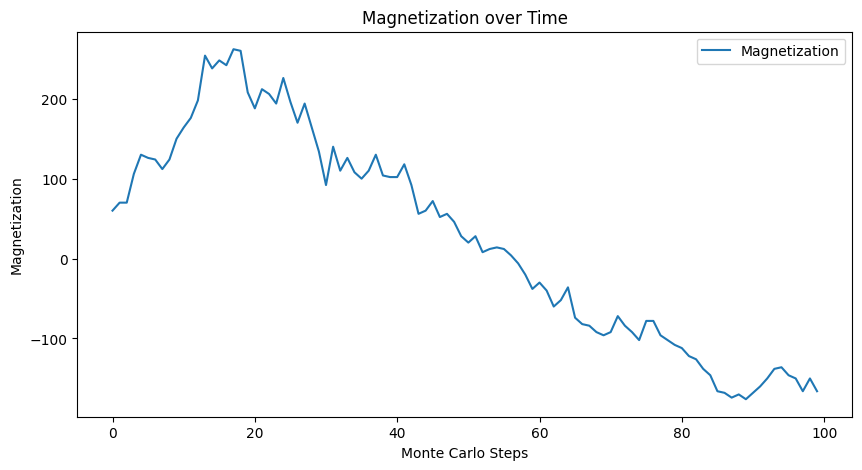

interactive(children=(IntSlider(value=0, description='t', max=99), Output()), _dom_classes=('widget-interact',…

In [4]:
# Running the simulation
model = LatticeSpinMarketModel(side=32, dim=2, J=1, alpha=4, T=1.5, steps=1000, local_field_func=local_field)
spin_series = model.run_simulation(verbose=True)
model.plot_magnetization(spin_series)
model.plot_lattice(spin_series=spin_series, interactive=True)